In [1]:
import types
import pandas as pd
from sklearn import preprocessing
import gc

Lendo o dataset de teste

In [2]:
testData = pd.read_json('C:/Users/hgfer/OneDrive/Documentos/Projeto ZAP/ZAP/source-4-ds-test.json',lines = True)

In [3]:
testData.head(2)

,address,bathrooms,bedrooms,createdAt,description,id,images,listingStatus,owner,parkingSpaces,pricingInfos,publicationType,publisherId,suites,title,totalAreas,unitTypes,updatedAt,usableAreas
0,"{'country': 'BR', 'zipCode': '01415000', 'city...",1.0,1,2015-10-20T20:52:41Z,Apartamentos de 1 dormitÃ³rio na Rua Bela Cint...,89224365f8,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,1.0,"{'price': None, 'businessType': 'SALE'}",STANDARD,967d57ce20,0.0,Apartamento Bela Cintra,47.0,APARTMENT,2018-11-08T15:02:53.953Z,47.0
1,"{'country': 'BR', 'zipCode': '03152155', 'city...",0.0,2,2018-07-31T06:10:07.427Z,"Ã“tima localizaÃ§Ã£o, prÃ³ximo ao shopping Cen...",363731333f,[http://images.ingaiasites.com.br/AolwiwJLLpET...,ACTIVE,False,1.0,"{'yearlyIptu': 0, 'price': None, 'businessType...",STANDARD,bddebf057a,0.0,"Apartamento residencial Ã venda, Quinta da Pa...",55.0,APARTMENT,2018-11-08T16:10:49.374Z,55.0


Lendo o dataset de treino


In [4]:
trainData = pd.read_json('C:/Users/hgfer/OneDrive/Documentos/Projeto ZAP/ZAP/source-4-ds-train.json', lines = True)

In [5]:
trainData.head(2)

,address,bathrooms,bedrooms,createdAt,description,id,images,listingStatus,owner,parkingSpaces,pricingInfos,publicationType,publisherId,suites,title,totalAreas,unitTypes,updatedAt,usableAreas
0,"{'country': 'BR', 'zipCode': '04290030', 'city...",3.0,4.0,2017-02-07T13:21:40Z,"04 dorms sendo 01 suÃ­te e closet, sala de est...",787c7bd19d,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,6.0,"{'price': 700000, 'businessType': 'SALE'}",STANDARD,f4603b2b52,1.0,PRÃ“XIMO A AVENIDA PRESIDENTE TANCREDO NEVES,388.0,TWO_STORY_HOUSE,2018-12-06T19:27:12.623Z,388.0
1,"{'country': 'BR', 'zipCode': '04187320', 'city...",2.0,3.0,2016-03-21T18:35:17Z,"03 dorms sendo 01 suÃ­te, sala, sala de jantar...",4d68c0cdbe,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,2.0,"{'price': 336000, 'businessType': 'SALE'}",STANDARD,f4603b2b52,1.0,PRÃ“XIMO A FACULDADE UNIP CAMPUS ANCHIETA,129.0,HOME,2018-12-12T13:17:23.547Z,129.0


# Data Preparation

## Address

### Zone

Verificou-se quantas quais zonas da cidade temos no dataset de treino

In [6]:
uniqueZoneTrain = []
for add in trainData.address:
    if add['zone'] not in uniqueZoneTrain:
        uniqueZoneTrain.append(add['zone'])

In [7]:
uniqueZoneTrain

['Zona Sul', '', 'Zona Leste', 'Zona Oeste', 'Centro', 'Zona Norte']

Costam 5 zonas: Sul, Leste, Oeste, Norte, Centro e alguns não possuem esta informação.

Notou-se que para os imóveis que possuem a feature zone vazia, é possivel obtê-la a partir da feature locationId.  

In [8]:
zoneTrain = []
for i in range(trainData.shape[0]):
    if trainData.address[i].get("zone") == '':
        zoneTrain.append(trainData.address[i].get("locationId"))
    else:
        zoneTrain.append(trainData.address[i].get("zone"))

É necessário realizar algumas alterações nas linhas que receberam a feature locationId ('BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira Cesar'), já que sua estrutura é diferente de zone ('Centro')

In [9]:
for i in range(len(zoneTrain)):
    if zoneTrain[i][0] == 'B':
        zoneTrain[i] = zoneTrain[i][28:34]


Transformando em pandas 

In [10]:
zone = pd.DataFrame(zoneTrain,columns = ['zone'])

Padronizando as zonas

In [11]:
zone.loc[zone["zone"] == "Zona S"] = "Zona Sul"
zone.loc[zone["zone"] == "Zona L"] = "Zona Leste"
zone.loc[zone["zone"] == "Zona O"] = "Zona Oeste"
zone.loc[zone["zone"] == "Zona N"] = "Zona Norte"

Verificando-se a quantidade de imóveis de cada região

In [12]:
zone["zone"].value_counts()

Zona Sul      48505
Zona Norte    28703
Zona Leste    24191
Zona Oeste    19620
Centro        12871
                 54
rrios>            5
rios>C            5
rios>V            2
e>Barr            1
rios>N            1
vo Ham            1
ios>Ce            1
rios>Q            1
Barrio            1
rios>S            1
anto d            1
Name: zone, dtype: int64

Notou-se que 74 imóveis não se encontram nas zonas pré definidas. E avaliando-se os dados verificou-se que estes imoveis não se encontram na cidade de São Paulo

In [13]:
zone.loc[zone["zone"] == "rrios>"] 

,zone
23220,rrios>
57587,rrios>
91839,rrios>
118857,rrios>
133565,rrios>


In [14]:
trainData.address[23220]["locationId"]

'BR>Sao Paulo>NULL>Itupeva>Barrios>Jardim Alegre'

Desta forma consideraremos estes dados como 'Outros', e a feature zone ficará da seguinte forma:

In [15]:
zone.loc[zone["zone"] == ""] = "Sem Zona"
zone.loc[zone["zone"] == "rrios>"] = "Fora SP"
zone.loc[zone["zone"] == "rios>C"] = "Fora SP"
zone.loc[zone["zone"] == "rios>V"] = "Fora SP"
zone.loc[zone["zone"] == "vo Ham"] = "Fora SP"
zone.loc[zone["zone"] == "rios>S"] = "Fora SP"
zone.loc[zone["zone"] == "e>Barr"] = "Fora SP"
zone.loc[zone["zone"] == "ios>Ce"] = "Fora SP"
zone.loc[zone["zone"] == "rios>N"] = "Fora SP"
zone.loc[zone["zone"] == "rios>Q"] = "Fora SP"
zone.loc[zone["zone"] == "anto d"] = "Fora SP"
zone.loc[zone["zone"] == "Barrio"] = "Fora SP"

In [16]:
zone["zone"].value_counts()

Zona Sul      48505
Zona Norte    28703
Zona Leste    24191
Zona Oeste    19620
Centro        12871
Sem Zona         54
Fora SP          20
Name: zone, dtype: int64

Analisando o dataset de teste com relação as regiões dos imóveis

In [17]:
zoneTest = []
for i in range(testData.shape[0]):
    if testData.address[i].get("zone") == '':
        zoneTest.append(testData.address[i].get("locationId"))
    else:
        zoneTest.append(testData.address[i].get("zone"))

In [18]:
for i in range(len(zoneTest)):
    if zoneTest[i][0] == 'B':
        zoneTest[i] = zoneTest[i][28:34]

In [19]:
zoneT = pd.DataFrame(zoneTest,columns = ['zone'])

In [20]:
zoneT.loc[zoneT["zone"] == "Zona S"] = "Zona Sul"
zoneT.loc[zoneT["zone"] == "Zona L"] = "Zona Leste"
zoneT.loc[zoneT["zone"] == "Zona O"] = "Zona Oeste"
zoneT.loc[zoneT["zone"] == "Zona N"] = "Zona Norte"

In [21]:
zoneT["zone"].value_counts()

Zona Sul      6278
Zona Leste    2876
Zona Norte    2853
Zona Oeste    2319
Centro        1697
                11
vo Ham           1
rios>V           1
Name: zone, dtype: int64

In [22]:
zoneT.loc[zoneT["zone"] == "rios>V"]

,zone
5416,rios>V


In [23]:
testData.address[5416].get("locationId")

'BR>Sao Paulo>NULL>Osasco>Barrios>Vila Yara'

In [24]:
zoneT.loc[zoneT["zone"] == "vo Ham"] = "Fora SP"
zoneT.loc[zoneT["zone"] == "rios>V"] = "Fora SP"
zoneT.loc[zoneT["zone"] == ""] = "Sem Zona"

In [25]:
zoneT["zone"].value_counts()

Zona Sul      6278
Zona Leste    2876
Zona Norte    2853
Zona Oeste    2319
Centro        1697
Sem Zona        11
Fora SP          2
Name: zone, dtype: int64

Assim como no dataset de treino, há imoveis fora da cidade de São Paulo.

## PricingInfos

In [26]:
trainData.head(2)

,address,bathrooms,bedrooms,createdAt,description,id,images,listingStatus,owner,parkingSpaces,pricingInfos,publicationType,publisherId,suites,title,totalAreas,unitTypes,updatedAt,usableAreas
0,"{'country': 'BR', 'zipCode': '04290030', 'city...",3.0,4.0,2017-02-07T13:21:40Z,"04 dorms sendo 01 suÃ­te e closet, sala de est...",787c7bd19d,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,6.0,"{'price': 700000, 'businessType': 'SALE'}",STANDARD,f4603b2b52,1.0,PRÃ“XIMO A AVENIDA PRESIDENTE TANCREDO NEVES,388.0,TWO_STORY_HOUSE,2018-12-06T19:27:12.623Z,388.0
1,"{'country': 'BR', 'zipCode': '04187320', 'city...",2.0,3.0,2016-03-21T18:35:17Z,"03 dorms sendo 01 suÃ­te, sala, sala de jantar...",4d68c0cdbe,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,2.0,"{'price': 336000, 'businessType': 'SALE'}",STANDARD,f4603b2b52,1.0,PRÃ“XIMO A FACULDADE UNIP CAMPUS ANCHIETA,129.0,HOME,2018-12-12T13:17:23.547Z,129.0


In [27]:
trainData.pricingInfos[2]

{'period': 'MONTHLY',
 'yearlyIptu': 4040,
 'price': 24929,
 'rentalTotalPrice': 29829,
 'businessType': 'RENTAL',
 'monthlyCondoFee': 4900}

### Period

Transformando a feature period em pandas

In [28]:
periodTrain = []
for i in range(trainData.shape[0]):
    periodTrain.append(trainData.pricingInfos[i].get("period"))

In [29]:
period = pd.DataFrame(periodTrain,columns = ['period'])

In [30]:
period["period"].value_counts()

MONTHLY    29029
DAILY         19
YEARLY         3
Name: period, dtype: int64

### YearlyIptu

Transformando a feature yearlyIptu em pandas


In [31]:
yearlyIptuTrain = []
for i in range(trainData.shape[0]):
    yearlyIptuTrain.append(trainData.pricingInfos[i].get("yearlyIptu"))

In [32]:
yearlyIptu = pd.DataFrame(yearlyIptuTrain,columns = ['yearlyIptu'])

### Price

Transformando a feature price em pandas

In [33]:
priceTrain = []
for i in range(trainData.shape[0]):
    priceTrain.append(trainData.pricingInfos[i].get("price"))

In [34]:
price = pd.DataFrame(priceTrain,columns = ['price'])

### RentalTotalPrice

Transformando a feature price em pandas


In [35]:
rentalTotalPriceTrain = []
for i in range(trainData.shape[0]):
    rentalTotalPriceTrain.append(trainData.pricingInfos[i].get("rentalTotalPrice"))

In [36]:
rentalTotalPrice = pd.DataFrame(rentalTotalPriceTrain,columns = ['rentalTotalPrice'])

### BusinessType

Transformando a feature businessType em pandas

In [37]:
businessTypeTrain = []
for i in range(trainData.shape[0]):
    businessTypeTrain.append(trainData.pricingInfos[i].get("businessType"))

In [38]:
businessType = pd.DataFrame(businessTypeTrain,columns = ['businessType'])

In [39]:
businessType["businessType"].value_counts()

SALE      105332
RENTAL     28632
Name: businessType, dtype: int64

Analisando a composição dos dados do dataset de teste com relção a feature buinessType

In [40]:
businessTypeTest = []
for i in range(testData.shape[0]):
    businessTypeTest.append(testData.pricingInfos[i].get("businessType"))

In [41]:
businessTypeT = pd.DataFrame(businessTypeTest,columns = ['businessType'])

In [42]:
businessTypeT["businessType"].value_counts()

SALE    16036
Name: businessType, dtype: int64

In [43]:
testData.shape

(16036, 19)

No dataset de treino todos as features businessType são SALE, logo todas as features RENTAL podem ser removidas do dataset de treino

### MonthlyCondoFee

Transformando a feature monthlyCondoFee em pandas

In [44]:
monthlyCondoFeeTrain = []
for i in range(trainData.shape[0]):
    monthlyCondoFeeTrain.append(trainData.pricingInfos[i].get("monthlyCondoFee"))

In [45]:
monthlyCondoFee = pd.DataFrame(monthlyCondoFeeTrain,columns = ['monthlyCondoFee'])

## UnitTypes

Transformando a feature unitTypes em pandas 

In [46]:
unitTypes = pd.DataFrame(trainData.unitTypes)

In [47]:
unitTypes["unitTypes"].value_counts()

APARTMENT                     72241
TWO_STORY_HOUSE               18068
HOME                           9030
OFFICE                         7714
FLAT                           7661
COMMERCIAL_PROPERTY            5871
CONDOMINIUM                    4015
PENTHOUSE                      2772
SHED_DEPOSIT_WAREHOUSE         2197
RESIDENTIAL_ALLOTMENT_LAND     1430
COMMERCIAL_ALLOTMENT_LAND       807
STORE                           694
BUSINESS                        663
KITNET                          522
RESIDENTIAL_BUILDING            142
COMMERCIAL_BUILDING              85
CLINIC                           33
FARM                             10
COUNTRY_HOUSE                     9
Name: unitTypes, dtype: int64

Verificando o tipo de imoveis no dataset de treino

In [48]:
unitTypesTest = pd.DataFrame(testData.unitTypes)

In [49]:
unitTypesTest["unitTypes"].value_counts()

APARTMENT    16036
Name: unitTypes, dtype: int64

No dataset de treino todos as features unitType são APARTMENT, logo todas as features diferentes disto podem ser removidas do dataset de treino

## TotalAreas

Um ponto a se levar em consideração é que as features totalAreas e usableAreas muitas vezes são iguais. Desta forma seria interessante, manter apenas uma das duas.

In [50]:
vecTotalAreasTrain = []
vecUsableAreasTrain = []
for i in range(trainData.shape[0]):
    vecTotalAreasTrain.append(trainData.totalAreas.get(i))
    vecUsableAreasTrain.append(trainData.usableAreas.get(i))
    if (vecTotalAreasTrain[i] == 0) & (vecUsableAreasTrain[i]< 400):
        vecTotalAreasTrain[i] = vecUsableAreasTrain[i]

In [51]:
areaTrain = pd.DataFrame(vecTotalAreasTrain,columns = ['area'])

Juntando todos os dados em apenas uma tabela obtém-se

In [52]:
trainData.head(2)

,address,bathrooms,bedrooms,createdAt,description,id,images,listingStatus,owner,parkingSpaces,pricingInfos,publicationType,publisherId,suites,title,totalAreas,unitTypes,updatedAt,usableAreas
0,"{'country': 'BR', 'zipCode': '04290030', 'city...",3.0,4.0,2017-02-07T13:21:40Z,"04 dorms sendo 01 suÃ­te e closet, sala de est...",787c7bd19d,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,6.0,"{'price': 700000, 'businessType': 'SALE'}",STANDARD,f4603b2b52,1.0,PRÃ“XIMO A AVENIDA PRESIDENTE TANCREDO NEVES,388.0,TWO_STORY_HOUSE,2018-12-06T19:27:12.623Z,388.0
1,"{'country': 'BR', 'zipCode': '04187320', 'city...",2.0,3.0,2016-03-21T18:35:17Z,"03 dorms sendo 01 suÃ­te, sala, sala de jantar...",4d68c0cdbe,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,2.0,"{'price': 336000, 'businessType': 'SALE'}",STANDARD,f4603b2b52,1.0,PRÃ“XIMO A FACULDADE UNIP CAMPUS ANCHIETA,129.0,HOME,2018-12-12T13:17:23.547Z,129.0


In [53]:
trainDataFinal = pd.concat([zone,trainData.bathrooms,trainData.bedrooms,trainData.parkingSpaces,period,yearlyIptu,rentalTotalPrice,businessType,monthlyCondoFee,trainData.suites,unitTypes,areaTrain,price], axis = 1)

In [54]:
trainDataFinal.head()

,zone,bathrooms,bedrooms,parkingSpaces,period,yearlyIptu,rentalTotalPrice,businessType,monthlyCondoFee,suites,unitTypes,area,price
0,Zona Sul,3.0,4.0,6.0,None,NaN,NaN,SALE,NaN,1.0,TWO_STORY_HOUSE,388.0,700000
1,Zona Sul,2.0,3.0,2.0,None,NaN,NaN,SALE,NaN,1.0,HOME,129.0,336000
2,Centro,4.0,0.0,5.0,MONTHLY,4040.0,29829.0,RENTAL,4900.0,0.0,COMMERCIAL_PROPERTY,NaN,24929
3,Zona Sul,2.0,3.0,2.0,None,1610.0,NaN,SALE,686.0,1.0,APARTMENT,80.0,739643
4,Zona Sul,5.0,4.0,5.0,None,18900.0,NaN,SALE,6230.0,4.0,APARTMENT,332.0,7520099


Conforme analisado acima é possível retirar os imóveis que estão para alugar e consequentemente a feature businessType.

In [55]:
trainReduce = trainDataFinal.drop(trainDataFinal[trainDataFinal["businessType"] == "RENTAL"].index)

In [56]:
trainDataFinal["businessType"].value_counts()

SALE      105332
RENTAL     28632
Name: businessType, dtype: int64

In [57]:
trainReduce["businessType"].value_counts()

SALE    105332
Name: businessType, dtype: int64

In [58]:
trainReduce = trainReduce.drop(columns = "businessType")

In [59]:
trainReduce.head(2)

,zone,bathrooms,bedrooms,parkingSpaces,period,yearlyIptu,rentalTotalPrice,monthlyCondoFee,suites,unitTypes,area,price
0,Zona Sul,3.0,4.0,6.0,None,NaN,NaN,NaN,1.0,TWO_STORY_HOUSE,388.0,700000
1,Zona Sul,2.0,3.0,2.0,None,NaN,NaN,NaN,1.0,HOME,129.0,336000


Verificando se soboru algum valor nas features period, rentalTotalPrice e yearlyIptu

In [60]:
trainReduce.shape

(105332, 12)

In [61]:
trainReduce["period"].value_counts()

MONTHLY    419
Name: period, dtype: int64

In [62]:
trainReduce["period"].isnull().sum(axis = 0)

104913

In [63]:
trainReduce["rentalTotalPrice"].value_counts()

0.0    95
Name: rentalTotalPrice, dtype: int64

In [64]:
trainReduce["rentalTotalPrice"].isnull().sum(axis = 0)

105237

In [65]:
trainReduce["yearlyIptu"].value_counts()

0.0         37717
70.0         1405
140.0        1195
8.0          1151
105.0         964
84.0          949
210.0         921
280.0         787
175.0         713
350.0         706
7.0           675
700.0         658
420.0         615
56.0          599
125.0         562
35.0          562
840.0         560
489.0         537
244.0         516
91.0          501
560.0         496
62.0          485
315.0         460
77.0          459
98.0          408
630.0         407
770.0         387
1050.0        377
49.0          363
42.0          361
            ...  
1263.0          1
18186.0         1
3604.0          1
2496.0          1
22166.0         1
1568.0          1
3814.0          1
3167.0          1
19826.0         1
4519.0          1
2153.0          1
36159.0         1
7769.0          1
2032.0          1
11089.0         1
2187.0          1
1474.0          1
3311.0          1
1709.0          1
3283.0          1
13142.0         1
144739.0        1
11096.0         1
23919.0         1
5550.0    

Com isso é possivel retirar as colunas period e rentalTotalPrice 

In [66]:
trainReduce = trainReduce.drop(['period','rentalTotalPrice'], axis = 1)

Como verificado anteriormente o dataset de teste contem apenas imoveis com a feature unitTypes = APARTMENT, logo podem ser removidas do dataset todas os imóveis que não são deste tipo

In [67]:
trainReduce = trainReduce.drop(trainReduce[trainReduce["unitTypes"] != "APARTMENT"].index)

Como restou-se apenas aprtamentos, é possivel remover a coluna unitTypes

In [68]:
trainReduce = trainReduce.drop(['unitTypes'], axis = 1)

In [69]:
trainReduce.head()

,zone,bathrooms,bedrooms,parkingSpaces,yearlyIptu,monthlyCondoFee,suites,area,price
3,Zona Sul,2.0,3.0,2.0,1610.0,686.0,1.0,80.0,739643
4,Zona Sul,5.0,4.0,5.0,18900.0,6230.0,4.0,332.0,7520099
6,Zona Oeste,1.0,3.0,2.0,489.0,1120.0,0.0,94.0,630700
9,Centro,4.0,4.0,2.0,0.0,0.0,3.0,141.0,1106000
10,Zona Sul,0.0,4.0,3.0,6300.0,1400.0,4.0,188.0,910000


# Data Processing

Com o data frame pronto é hora de veirificar se existem outliers

In [70]:
import numpy as np # linear algebra
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignora warnings desnecessários do sklearn e seaborn


from scipy import stats
from scipy.stats import norm, skew #estatistica


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #limitando floats a 3 casas decimais



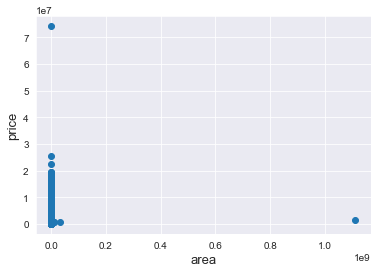

In [71]:
fig, ax = plt.subplots()
ax.scatter(x = trainReduce['area'], y = trainReduce['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('area', fontsize=13)
plt.show()

É possível vizualizar que existem imóveis cuja area é muito grande, destacando-se como outliers. Com isso é possível romovê-los do dataset.

In [72]:
trainReduce = trainReduce.drop(trainReduce[trainReduce["area"] > 15000].index)

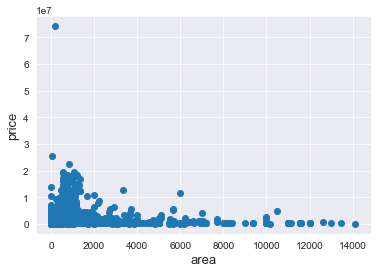

In [73]:
fig, ax = plt.subplots()
ax.scatter(x = trainReduce['area'], y = trainReduce['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('area', fontsize=13)
plt.show()

Ainda é possivel verificar que imoveis com área acima de 500 representam apenas 2%. Com isso a fim, de minimizar a distorção dos dados, serão desconsiderados imoveis com area maior que 500. O mesmo ocorre com imoveis com preço superior a 25000000

In [74]:
trainReduce.shape

(64105, 9)

In [75]:
trainReduce[trainReduce["area"]>500].shape

(1293, 9)

In [76]:
trainReduce = trainReduce.drop(trainReduce[trainReduce["area"] > 500].index)

In [77]:
trainReduce = trainReduce.drop(trainReduce[trainReduce["price"] > 25000000].index)

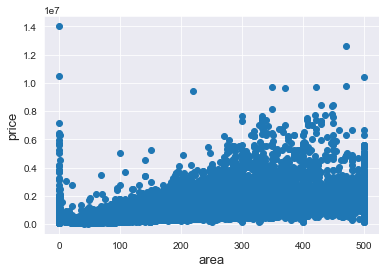

In [78]:
fig, ax = plt.subplots()
ax.scatter(x = trainReduce['area'], y = trainReduce['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('area', fontsize=13)
plt.show()

Pode-se vizualizar que ainda há outiliers. Logo imoveis com preço acima de 8000000 serão desconsiderados

In [79]:
trainReduce = trainReduce.drop(trainReduce[trainReduce["price"] > 8000000].index)

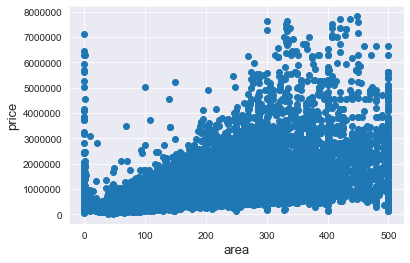

In [80]:
fig, ax = plt.subplots()
ax.scatter(x = trainReduce['area'], y = trainReduce['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('area', fontsize=13)
plt.show()

Agora vamos avaliar a feature price com relação a sua distribuição


 mu = 709879.42 and sigma = 755794.84



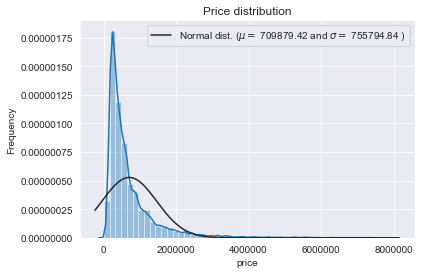

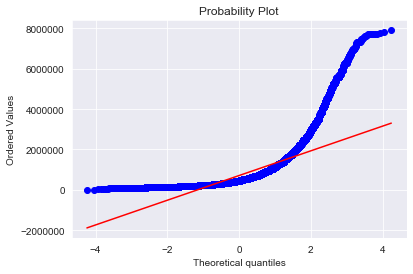

In [81]:
sns.distplot(trainReduce['price'] , fit = norm);

#Pegando os paramentros ajustados utilizados pela função
(mu, sigma) = norm.fit(trainReduce['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Plotando a distribuição
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Traçando o gráfico QQ
fig = plt.figure()
res = stats.probplot(trainReduce['price'], plot=plt)
plt.show()

A partir dos gráficos verificou-se que a ditribuição dos preços esta deslocada, e a fim de tranformá-la em uma distribuição normal, aplicou-se a escala logarítmica


 mu = 13.13 and sigma = 0.78



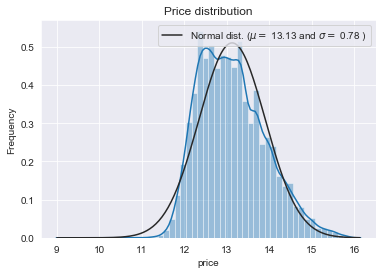

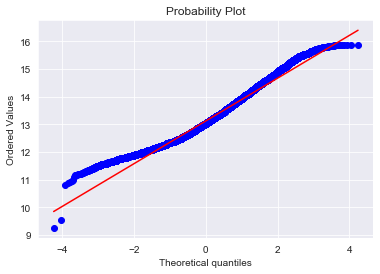

In [82]:
#Usando a função log1p da biblioteca numpy, ela aplica log(1+x) a todos os elementos da coluna
trainReduce["price"] = np.log1p(trainReduce["price"])

#Checando a nova distribuição 
sns.distplot(trainReduce['price'] , fit = norm)

#Pegando os paramentros ajustados utilizados pela função
(mu, sigma) = norm.fit(trainReduce['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Plotando a distribuição
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc = 'best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Traçando o gráfico QQ
fig = plt.figure()
res = stats.probplot(trainReduce['price'], plot = plt)
plt.show()

## Matriz de correlação

[Text(0.5, 0, 'bathrooms'),
 Text(1.5, 0, 'bedrooms'),
 Text(2.5, 0, 'parkingSpaces'),
 Text(3.5, 0, 'yearlyIptu'),
 Text(4.5, 0, 'monthlyCondoFee'),
 Text(5.5, 0, 'suites'),
 Text(6.5, 0, 'area'),
 Text(7.5, 0, 'price')]

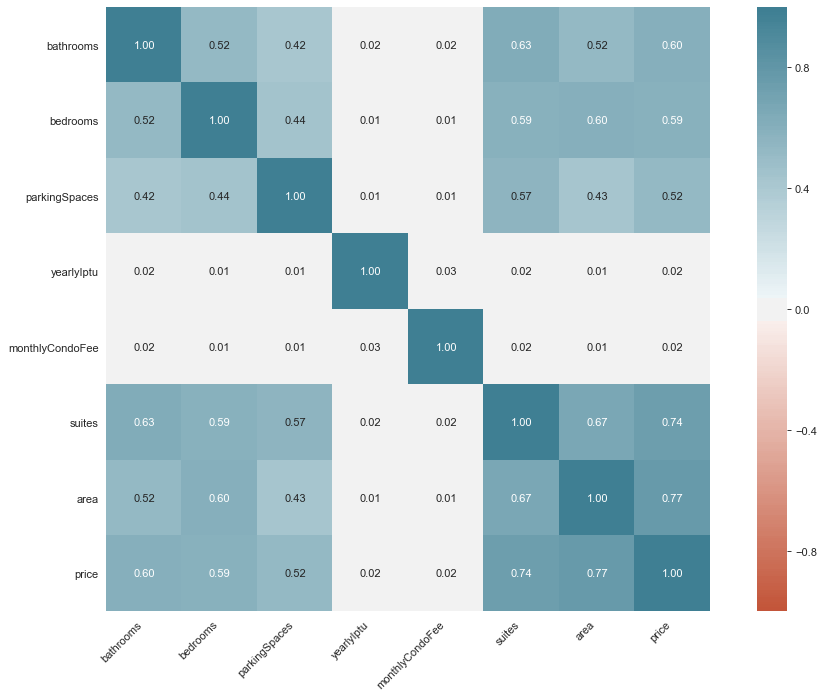

In [83]:
#Matriz de Correlação p/ variaveis numericas
corr = trainReduce.corr()
plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    fmt = '.2f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## Dados faltantes

Para juntar-se os dados de teste e treino, primeiramente é necessário ajustar os dados de teste

In [84]:
trainReduce.head(2)

,zone,bathrooms,bedrooms,parkingSpaces,yearlyIptu,monthlyCondoFee,suites,area,price
3,Zona Sul,2.000,3.000,2.000,1610.000,686.000,1.000,80.000,13.514
4,Zona Sul,5.000,4.000,5.000,18900.000,6230.000,4.000,332.000,15.833


In [85]:
yearlyIptuTest = []
for i in range(testData.shape[0]):
    yearlyIptuTest.append(testData.pricingInfos[i].get("yearlyIptuTest"))

In [86]:
yearlyIptuT = pd.DataFrame(yearlyIptuTest,columns = ['yearlyIptu'])

In [87]:
monthlyCondoFeeTest = []
for i in range(testData.shape[0]):
    monthlyCondoFeeTest.append(testData.pricingInfos[i].get("monthlyCondoFee"))

In [88]:
monthlyCondoFeeT = pd.DataFrame(monthlyCondoFeeTest,columns = ['monthlyCondoFee'])

In [89]:
priceTest = []
for i in range(testData.shape[0]):
    priceTest.append(testData.pricingInfos[i].get("price"))

In [90]:
priceT = pd.DataFrame(priceTest,columns = ['price'])

In [91]:
vecTotalAreasTest = []
vecUsableAreasTest = []
for i in range(testData.shape[0]):
    vecTotalAreasTest.append(testData.totalAreas.get(i))
    vecUsableAreasTest.append(testData.usableAreas.get(i))
    if (vecTotalAreasTest[i] == 0) & (vecUsableAreasTest[i]< 400):
        vecTotalAreasTest[i] = vecUsableAreasTest[i]

In [92]:
areaTest = pd.DataFrame(vecTotalAreasTest,columns = ['area'])

In [93]:
testDataFinal = pd.concat([zoneT,testData.bathrooms,testData.bedrooms,testData.parkingSpaces,yearlyIptuT,monthlyCondoFeeT,testData.suites,areaTest,priceT], axis = 1) 

In [94]:
testDataFinal.head(2)

,zone,bathrooms,bedrooms,parkingSpaces,yearlyIptu,monthlyCondoFee,suites,area,price
0,Centro,1.000,1,1.000,None,nan,0.000,47.000,None
1,Zona Leste,0.000,2,1.000,None,0.000,0.000,55.000,None


Juntando os dataset de teste e de treino

In [95]:
ntrain = trainReduce.shape[0]
ntest = testDataFinal.shape[0]
yTrain = trainReduce.price.values
allData = pd.concat((trainReduce, testDataFinal)).reset_index(drop = True)
allData.drop(['price'], axis = 1, inplace = True)
print("all_data size is : {}".format(allData.shape))

all_data size is : (78778, 8)


In [96]:
allDataMissing = (allData.isnull().sum() / len(allData)) * 100
allDataMissing = allDataMissing.drop(allDataMissing[allDataMissing == 0].index).sort_values(ascending=False)[:30]
missingData = pd.DataFrame({'Missing Ratio' :allDataMissing})
missingData.head(20)

,Missing Ratio
area,39.345
yearlyIptu,32.386
suites,8.876
monthlyCondoFee,5.725
parkingSpaces,1.752
bathrooms,0.003


Substituindo dos dados faltantes pela média  de todos os imóveis da região, exceto para o parking spaces e suites que serão substituidos por zero.

In [97]:
allData["area"] = allData.groupby("zone")["area"].transform(
    lambda x: x.fillna(x.median()))

In [98]:
allData["yearlyIptu"] = allData.groupby("zone")["yearlyIptu"].transform(
    lambda x: x.fillna(x.median()))

In [99]:
for col in ('suites', 'parkingSpaces'):
    allData[col] = allData[col].fillna(0)

In [100]:
allData["monthlyCondoFee"] = allData.groupby("zone")["monthlyCondoFee"].transform(
    lambda x: x.fillna(x.median()))

In [101]:
allData["bathrooms"] = allData.groupby("zone")["bathrooms"].transform(
    lambda x: x.fillna(x.median()))

Checaando novamente os dado faltantes

In [102]:
allDataMissing = (allData.isnull().sum() / len(allData)) * 100
allDataMissing = allDataMissing.drop(allDataMissing[allDataMissing == 0].index).sort_values(ascending=False)[:30]
missingData = pd.DataFrame({'Missing Ratio' :allDataMissing})
missingData.head(20)

,Missing Ratio


Transformando a feature zone em uma variável numérica

In [103]:
allData = allData.replace("Zona Sul",1)
allData = allData.replace("Zona Leste",2)
allData = allData.replace("Zona Oeste",3)
allData = allData.replace("Zona Norte",4)
allData = allData.replace("Centro",5)
allData = allData.replace("Fora SP",6)
allData = allData.replace("Sem Zona",7)

In [104]:
allData.head()

,zone,bathrooms,bedrooms,parkingSpaces,yearlyIptu,monthlyCondoFee,suites,area
0,1,2.000,3.000,2.000,1610.000,686.000,1.000,80.000
1,1,5.000,4.000,5.000,18900.000,6230.000,4.000,332.000
2,3,1.000,3.000,2.000,489.000,1120.000,0.000,94.000
3,5,4.000,4.000,2.000,0.000,0.000,3.000,141.000
4,1,0.000,4.000,3.000,6300.000,1400.000,4.000,188.000


Separando os dados de treino dos dados de teste

In [105]:
trainSet = allData[:ntrain]
testSet = allData[ntrain:]

In [106]:
trainSet.head()

,zone,bathrooms,bedrooms,parkingSpaces,yearlyIptu,monthlyCondoFee,suites,area
0,1,2.000,3.000,2.000,1610.000,686.000,1.000,80.000
1,1,5.000,4.000,5.000,18900.000,6230.000,4.000,332.000
2,3,1.000,3.000,2.000,489.000,1120.000,0.000,94.000
3,5,4.000,4.000,2.000,0.000,0.000,3.000,141.000
4,1,0.000,4.000,3.000,6300.000,1400.000,4.000,188.000


In [107]:
testSet.head()

,zone,bathrooms,bedrooms,parkingSpaces,yearlyIptu,monthlyCondoFee,suites,area
62742,5,1.000,1.000,1.000,105.000,700.000,0.000,47.000
62743,2,0.000,2.000,1.000,28.000,0.000,0.000,55.000
62744,4,3.000,3.000,2.000,0.000,686.000,1.000,66.000
62745,1,4.000,3.000,3.000,112.000,770.000,3.000,145.000
62746,3,2.000,2.000,1.000,84.000,472.000,1.000,76.000


# Modelling

Importando as bibliotecas necessárias

In [108]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Cross Validation

Utilizou-se a função cross_val_score da biblioteca Sklearn, porém ela não possui um modo aleatório. Com isso adicionou-se as seguintes linhas de códiog para realizar esta função.

In [109]:
nFolds = 5

def rmsle_cv(model):
    kf = KFold(nFolds, shuffle = True, random_state = 42).get_n_splits(trainSet.values)
    rmse = np.sqrt(-cross_val_score(model, trainSet.values, yTrain, scoring = "neg_mean_squared_error", cv = kf))
    return(rmse)

## Modelos

A seguir são apresentados os modelos que serão utilizados

### LASSO Regression

In [110]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))

### Elastic Net Regression

In [111]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = .9, random_state = 3))

### Gradient Boosting Regression

In [113]:
GBoost = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = 'sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = 'huber', random_state = 5)

### XGBoost

In [114]:
modelXGB = xgb.XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                             learning_rate = 0.05, max_depth = 3, 
                             min_child_weight = 1.7817, n_estimators = 2200,
                             reg_alpha = 0.4640, reg_lambda = 0.8571,
                             subsample = 0.5213, silent = 1,
                             random_state = 7, nthread = -1)

## LightGBM

In [116]:
modelLGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## Performance dos modelos

Utilizando a função rmsle_cv verificou-se o erro de cada modelo dentro do dataset de treino

In [117]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4868 (0.0289)



In [118]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.4868 (0.0289)



In [120]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.3023 (0.0485)



In [121]:
score = rmsle_cv(modelXGB)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.3096 (0.0461)



In [122]:
score = rmsle_cv(modelLGB)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.3493 (0.0389)



De acordo com os testes vemos que o modelo que performou melhor foi Gradient Boosting Regression. 

Agora definimos a função que determinha o erro do modelo

In [127]:
def rmsle(y, yPred):
    return np.sqrt(mean_squared_error(y, yPred))

In [128]:
GBoost.fit(trainSet, yTrain)
GBoostTrainPred = GBoost.predict(trainSet)
GBoostPred = np.expm1(GBoost.predict(testSet.values))
print(rmsle(yTrain, GBoostTrainPred))

0.26599562580447544


# Performace por região

In [173]:
x = pd.DataFrame(yTrain,columns = ['priceReal'])
y = pd.DataFrame(trainSet.zone,columns = ['zone'])
z = pd.DataFrame(GBoostTrainPred,columns = ['pricePred'])
perform = pd.concat([y,x,z], axis = 1)
   

## Zona Sul

In [184]:
rmsle(perform[perform["zone"]==1].priceReal,perform[perform["zone"]==1].pricePred)

0.306182570112786

## Zona Leste

In [185]:
rmsle(perform[perform["zone"]==2].priceReal,perform[perform["zone"]==2].pricePred)

0.22364517576342338

## Zona Oeste

In [186]:
rmsle(perform[perform["zone"]==3].priceReal,perform[perform["zone"]==3].pricePred)

0.2825726479435041

## Zona Norte

In [187]:
rmsle(perform[perform["zone"]==4].priceReal,perform[perform["zone"]==4].pricePred)

0.20329499718399519

## Centro

In [188]:
rmsle(perform[perform["zone"]==5].priceReal,perform[perform["zone"]==5].pricePred)

0.2428521200185569

## Fora SP

In [189]:
rmsle(perform[perform["zone"]==6].priceReal,perform[perform["zone"]==6].pricePred)

0.17523545690808276

## Sem Zona

In [190]:
rmsle(perform[perform["zone"]==7].priceReal,perform[perform["zone"]==7].pricePred)

0.2205375565262741

Com isso verificou-se que o menor erro ocorre na região fora de SP

# Submission

In [191]:
sub = pd.DataFrame()
sub['id'] = testData.id
sub['price'] = GBoostPred
sub.to_csv('HousePrice.csv',index=False)

In [136]:
sub

,id,price
0,89224365f8,331869.142
1,363731333f,205255.730
2,6e6283378a,500101.340
3,4c29a27f44,1120061.677
4,7b16cf224b,414086.701
5,c0c699ebcc,336461.713
6,d36b41a815,201445.627
7,9be92984b9,591690.406
8,f774771058,244875.805
9,0c4add382a,1811347.758
